Preprocesamiento
- No hace falta estandarizar, no estaría tampoco mal
- Agrupar las binarias (has..) en grupos
  - has_secondary_use (hay que añadir más para las combinaciones)
  - has_superstructure
- geo_level3 o 2 quizás se puedan agrupar en intervalos
- Pasar las categóricas a números ? En sí las letras no tienen significado
- Quizás agrupar la edad en intervalos
- Ver qué hacer con las duplicadas
- Los árboles son robustos al ruido, así que las variables extremadamente 
desbalanceadas no deberían hacer mucho daño. Considerar si quitar o no según el
coste computacional que haya en principio.
- Age de 995 mantenerlo, a ver si el árbol consigue algo del estilo if age>200 ...

- Quizá la distancia, al ser datos del mismo terremoto sea muy relevante. 
Se podría reflejar en una combinación de las has_structure y geom_ids 
(el epicentro estaría por unos valores concretos de geom_id)

-------

- No necesitamos normalizar los datos en árboles. Además, no hacerlo nos ayudará a interpretar

In [39]:
################################################################################
# Libraries
################################################################################

import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns

# Preprocesamiento
# from sklearn.preprocessing import Normalizer
# from sklearn.decomposition import PCA
from imblearn.under_sampling import EditedNearestNeighbours, TomekLinks, CondensedNearestNeighbour
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif


In [5]:
################################################################################
# Load data
################################################################################

train_values = pd.read_csv("data/train_values.csv")
test_values  = pd.read_csv("data/test_values.csv")
train_labels = pd.read_csv("data/train_labels.csv")

preprocessed_train = train_values
preprocessed_test = test_values


In [5]:
for i,c in enumerate(preprocessed_train.columns):
    print(i, c)

0 building_id
1 geo_level_1_id
2 geo_level_2_id
3 geo_level_3_id
4 count_floors_pre_eq
5 age
6 area_percentage
7 height_percentage
8 land_surface_condition
9 foundation_type
10 roof_type
11 ground_floor_type
12 other_floor_type
13 position
14 plan_configuration
15 has_superstructure_adobe_mud
16 has_superstructure_mud_mortar_stone
17 has_superstructure_stone_flag
18 has_superstructure_cement_mortar_stone
19 has_superstructure_mud_mortar_brick
20 has_superstructure_cement_mortar_brick
21 has_superstructure_timber
22 has_superstructure_bamboo
23 has_superstructure_rc_non_engineered
24 has_superstructure_rc_engineered
25 has_superstructure_other
26 legal_ownership_status
27 count_families
28 has_secondary_use
29 has_secondary_use_agriculture
30 has_secondary_use_hotel
31 has_secondary_use_rental
32 has_secondary_use_institution
33 has_secondary_use_school
34 has_secondary_use_industry
35 has_secondary_use_health_post
36 has_secondary_use_gov_office
37 has_secondary_use_use_police
38 has_s

### IDEA

Join columns
- 15...25 (has superstructure) (they are not dummy variables, use combination)
- 29...38 (has sencondary use) (probably dummy variables)

Remove 28, not needed

Reorder numerics next to numerics

In [14]:
# No hay duplicados en los ids, se pueden quitar
# preprocessed_train.building_id.duplicated

preprocessed_train = preprocessed_train.drop(columns="building_id")
preprocessed_test = preprocessed_test.drop(columns="building_id")

# Lo mismo con las etiquetas
train_labels = train_labels.drop(columns="building_id")

In [7]:
############################################################################
# Preprocesado Nº 2
############################################################################

# Quitamos geo_2 y geo_3. Tienen demasiadas categorías diferentes para los árboles,
# y no se solapan
preprocessed_train = preprocessed_train.drop(columns=["geo_level_2_id","geo_level_3_id"])
preprocessed_test = preprocessed_test.drop(columns=["geo_level_2_id","geo_level_3_id"])


# En estas dos predomina (+85%) una clase y el resto no sirve para determinar
# ninguna etiqueta (se mantiene la proporción o las 3 están representadas)
preprocessed_train = preprocessed_train.drop(columns=["plan_configuration","legal_ownership_status"])
preprocessed_test = preprocessed_test.drop(columns=["plan_configuration","legal_ownership_status"])

In [8]:
# Altura y nº de plantas altamente correladas, categorizamos nº de plantas y quitamos altura
# Solo una instancia con 9 plantas, y las anteriores no siguen el mismo patrón (que todas sufrieran el mismo tipo de daño)
# Como tenemos proporciones muy similares, juntamos las +5 con ella
preprocessed_train["count_floors_pre_eq"] = preprocessed_train["count_floors_pre_eq"].replace({6:5, 7:5, 8:5, 9:5})
preprocessed_test["count_floors_pre_eq"] = preprocessed_test["count_floors_pre_eq"].replace({6:5, 7:5, 8:5, 9:5})

# No nos interesan variables numéricas en los árboles, acabarían discretizándose
preprocessed_train = preprocessed_train.drop(columns=["height_percentage"])
preprocessed_test = preprocessed_test.drop(columns=["height_percentage"])


In [9]:
preprocessed_train

,geo_level_1_id,count_floors_pre_eq,age,area_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,6,2,30,6,t,r,n,f,q,t,...,0,0,0,0,0,0,0,0,0,0
1,8,2,10,8,o,r,n,x,q,s,...,0,0,0,0,0,0,0,0,0,0
2,21,2,10,5,t,r,n,f,x,t,...,0,0,0,0,0,0,0,0,0,0
3,22,2,10,6,t,r,n,f,x,s,...,0,0,0,0,0,0,0,0,0,0
4,11,3,30,8,t,r,n,f,x,s,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260596,25,1,55,6,n,r,n,f,j,s,...,0,0,0,0,0,0,0,0,0,0
260597,17,2,0,6,t,r,n,f,q,s,...,0,0,0,0,0,0,0,0,0,0
260598,17,3,55,6,t,r,q,f,q,s,...,0,0,0,0,0,0,0,0,0,0
260599,26,2,10,14,t,r,x,v,s,j,...,0,0,0,0,0,0,0,0,0,0


In [47]:
# One-hot-enconding
label_encoders = {}
categorical_columns = ["geo_level_1_id",
                        # "count_floors_pre_eq",
                        # "age",
                        # "area_percentage",
                        "land_surface_condition",
                        "foundation_type",
                        "roof_type",
                        "ground_floor_type",
                        "other_floor_type",
                        "position",
                        # "count_families",
                        # "has_superstructure",
                        # "has_secondary"
                       ]
for column in categorical_columns:
    # Para training
    dummies = pd.get_dummies(preprocessed_train[column])
    dummies.columns = [column + "_" + str(x) for x in dummies.columns]
    preprocessed_train = preprocessed_train.drop(columns=column)
    preprocessed_train = pd.concat([preprocessed_train, dummies], axis=1)

    # Para test
    dummies = pd.get_dummies(preprocessed_test[column])
    dummies.columns = [column + "_" + str(x) for x in dummies.columns]
    preprocessed_test = preprocessed_test.drop(columns=column)
    preprocessed_test = pd.concat([preprocessed_test, dummies], axis=1)


In [11]:
preprocessed_train

,count_floors_pre_eq,age,area_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,...,ground_floor_type_x,ground_floor_type_z,other_floor_type_j,other_floor_type_q,other_floor_type_s,other_floor_type_x,position_j,position_o,position_s,position_t
0,2,30,6,1,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1,2,10,8,0,1,0,0,0,0,0,...,1,0,0,1,0,0,0,0,1,0
2,2,10,5,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
3,2,10,6,0,1,0,0,0,0,1,...,0,0,0,0,0,1,0,0,1,0
4,3,30,8,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260596,1,55,6,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
260597,2,0,6,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
260598,3,55,6,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
260599,2,10,14,0,0,0,0,0,1,0,...,0,0,0,0,1,0,1,0,0,0


In [26]:
# Preprocesado 3.1
# Selección de características
# For classification: chi2, f_classif, mutual_info_classif
selector = SelectKBest(chi2, k=10)
selector.fit(preprocessed_train, train_labels)
X_new = selector.transform(preprocessed_train)


In [43]:
columns = preprocessed_train.columns[selector.get_support()]
columns

Index(['age', 'area_percentage', 'has_superstructure_cement_mortar_brick',
       'has_superstructure_rc_engineered', 'geo_level_1_id_17',
       'geo_level_1_id_26', 'foundation_type_i', 'roof_type_x',
       'ground_floor_type_v', 'other_floor_type_s'],
      dtype='object')

In [38]:
# what are scores for the features
pd.DataFrame(selector.scores_).transpose()

,0,1,2,3,4,5,6,7,8,9,...,71,72,73,74,75,76,77,78,79,80
0,1260.091,89437.601578,11938.314627,1340.145544,6969.601844,1108.404575,936.793309,987.065751,18949.414382,977.290073,...,60.551665,122.429528,7422.919931,5108.46128,18549.408221,406.60249,259.354872,148.779877,49.37144,622.421247


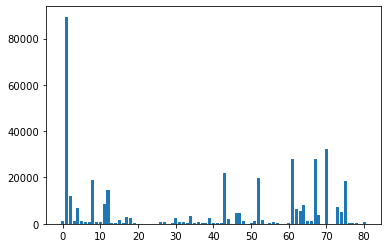

In [33]:
# plot the scores
plt.bar([i for i in range(len(selector.scores_))], selector.scores_)
plt.show()

In [27]:
X_new

array([[30,  6,  0, ...,  0,  0,  0],
       [10,  8,  0, ...,  0,  0,  0],
       [10,  5,  0, ...,  0,  0,  0],
       ...,
       [55,  6,  0, ...,  0,  0,  0],
       [10, 14,  1, ...,  1,  1,  1],
       [10,  7,  0, ...,  0,  0,  0]], dtype=int64)

In [28]:
# define the undersampling method
# Se prueba con los siguiente, no se reduce el desbalanceo (en CNN sí ??)
# USAR MÉTODOS DE SELECCIÓN DE CARACACTERÍSTICAS ANTES, QUIZÁS DECIR QUE GEO1 Y FLOOR... SON LAS QUE SE ELIGEN MEDIANTE UN ARBOL
# MIRAR SMOTE PARA OVERSAMPLING

# Quizás no estaría mal reducir el desbalanceo
# https://stats.stackexchange.com/questions/28029/training-a-decision-tree-against-unbalanced-data

# undersample = TomekLinks()
# undersample = CondensedNearestNeighbour(n_neighbors=1)
undersample = EditedNearestNeighbours(n_neighbors=3)
# transform the dataset
X, y = undersample.fit_resample(X_new, train_labels)

In [42]:
print(len(X))
print(len(X_new))

81120
260601


In [51]:
# X = pd.DataFrame(X, columns=columns)
preprocessed_train = X
train_labels = y

In [49]:
# Select same feautures as with train
preprocessed_test = selector.transform(preprocessed_test)
preprocessed_test = pd.DataFrame(preprocessed_test, columns=columns)
preprocessed_test

,age,area_percentage,has_superstructure_cement_mortar_brick,has_superstructure_rc_engineered,geo_level_1_id_17,geo_level_1_id_26,foundation_type_i,roof_type_x,ground_floor_type_v,other_floor_type_s
0,20,7,0,0,1,0,0,0,0,0
1,25,13,0,0,0,0,0,0,0,0
2,5,4,0,0,0,0,0,0,0,0
3,0,19,1,0,0,1,0,1,1,0
4,15,8,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
86863,70,20,0,0,0,0,0,0,0,0
86864,25,6,0,0,0,0,0,0,0,0
86865,50,3,0,0,0,0,0,0,0,0
86866,5,9,0,0,0,0,0,0,0,0


In [52]:
preprocessed_train

,age,area_percentage,has_superstructure_cement_mortar_brick,has_superstructure_rc_engineered,geo_level_1_id_17,geo_level_1_id_26,foundation_type_i,roof_type_x,ground_floor_type_v,other_floor_type_s
0,0,8,1,0,0,0,0,0,1,0
1,0,13,1,0,0,1,1,0,1,0
2,0,9,0,0,0,0,0,0,0,0
3,5,11,0,0,0,0,1,1,1,0
4,0,15,1,0,0,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...
81115,5,11,0,0,1,0,0,0,0,0
81116,10,15,0,0,1,0,0,0,0,0
81117,5,6,0,0,1,0,0,0,0,0
81118,0,6,0,0,1,0,0,0,0,0


In [53]:
train_labels

,damage_grade
0,1
1,1
2,1
3,1
4,1
...,...
81115,3
81116,3
81117,3
81118,3


In [54]:
################################################################################
# Write data
################################################################################
# preprocessed_train.to_csv("data/preprocessed_train.csv", index=False)
# train_labels.to_csv("data/train_labels.csv", index=False)
# preprocessed_test.to_csv("data/preprocessed_test.csv", index=False)

In [ ]:
# https://datascience.stackexchange.com/questions/43444/how-to-evaluate-feature-quality-for-decision-tree-model
# https://machinelearningmastery.com/feature-selection-with-categorical-data/

#####################################################################################################
#####################################################################################################
#####################################################################################################

In [8]:
# Join has_superstructure (binary) columns has strings
# Get selected rows to string
df = preprocessed_train.iloc[:,15:25].astype(str)
df_test = preprocessed_test.iloc[:,15:25].astype(str)

# Join them
preprocessed_train["has_superstructure"] = df.apply(lambda x: ''.join(x), axis=1)
preprocessed_test["has_superstructure"] = df_test.apply(lambda x: ''.join(x), axis=1)

In [9]:
# Join has_secondary (binary) columns has strings
# Get selected rows to string
df = preprocessed_train.iloc[:,29:38].astype(str)
df_test = preprocessed_test.iloc[:,29:38].astype(str)

# Join them
preprocessed_train["has_secondary"] = df.apply(lambda x: ''.join(x), axis=1)
preprocessed_test["has_secondary"] = df_test.apply(lambda x: ''.join(x), axis=1)

In [10]:
# Remove joined columns
removed_cols = list(range(15,26)) + list(range(29,39))
preprocessed_train = preprocessed_train.drop(columns=preprocessed_train.columns[removed_cols])
preprocessed_test = preprocessed_test.drop(columns=preprocessed_test.columns[removed_cols])

preprocessed_train

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,legal_ownership_status,count_families,has_secondary_use,has_superstructure,has_secondary
0,802906,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,v,1,0,1100000000,000000000
1,28830,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,v,1,0,0100000000,000000000
2,94947,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,v,1,0,0100000000,000000000
3,590882,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,v,1,0,0100001100,000000000
4,201944,11,131,1488,3,30,8,9,t,r,n,f,x,s,d,v,1,0,1000000000,000000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260596,688636,25,1335,1621,1,55,6,3,n,r,n,f,j,s,q,v,1,0,0100000000,000000000
260597,669485,17,715,2060,2,0,6,5,t,r,n,f,q,s,d,v,1,0,0100000000,000000000
260598,602512,17,51,8163,3,55,6,7,t,r,q,f,q,s,d,v,1,0,0100000000,000000000
260599,151409,26,39,1851,2,10,14,6,t,r,x,v,s,j,d,v,1,0,0000010000,000000000


In [11]:
# Convert new cols to int
# preprocessed_train["has_superstructure"] = preprocessed_train["has_superstructure"].apply(lambda x: int(x,2))
# preprocessed_train["has_secondary"] = preprocessed_train["has_secondary"].apply(lambda x: int(x,2))
# preprocessed_train

In [12]:
# Convert to categorical in order (TODO: KEEP ORIGINAL MAPPING)
# MEJOR: Leerlo como factor en R

# preprocessed_train.has_secondary = preprocessed_train.has_secondary.astype("category").cat.codes
# preprocessed_train.has_superstructure = preprocessed_train.has_superstructure.astype('category').cat.codes

# preprocessed_train

In [14]:
# has_secondary_use is enconded in has_secondary, remove it
preprocessed_train = preprocessed_train.drop(columns="has_secondary_use")
preprocessed_test = preprocessed_test.drop(columns="has_secondary_use")
preprocessed_train

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,legal_ownership_status,count_families,has_superstructure,has_secondary
0,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,v,1,1100000000,000000000
1,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,v,1,0100000000,000000000
2,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,v,1,0100000000,000000000
3,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,v,1,0100001100,000000000
4,11,131,1488,3,30,8,9,t,r,n,f,x,s,d,v,1,1000000000,000000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260596,25,1335,1621,1,55,6,3,n,r,n,f,j,s,q,v,1,0100000000,000000000
260597,17,715,2060,2,0,6,5,t,r,n,f,q,s,d,v,1,0100000000,000000000
260598,17,51,8163,3,55,6,7,t,r,q,f,q,s,d,v,1,0100000000,000000000
260599,26,39,1851,2,10,14,6,t,r,x,v,s,j,d,v,1,0000010000,000000000


In [17]:
pd.unique(preprocessed_train.count_floors_pre_eq)

array([2, 3, 1, 4, 5], dtype=int64)

In [18]:
train_labels

,building_id,damage_grade
0,802906,3
1,28830,2
2,94947,3
3,590882,2
4,201944,3
...,...,...
260596,688636,2
260597,669485,3
260598,602512,3
260599,151409,2


In [19]:
preprocessed_train

,geo_level_1_id,count_floors_pre_eq,age,area_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,count_families,has_superstructure,has_secondary
0,6,2,30,6,t,r,n,f,q,t,1,1100000000,000000000
1,8,2,10,8,o,r,n,x,q,s,1,0100000000,000000000
2,21,2,10,5,t,r,n,f,x,t,1,0100000000,000000000
3,22,2,10,6,t,r,n,f,x,s,1,0100001100,000000000
4,11,3,30,8,t,r,n,f,x,s,1,1000000000,000000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
260596,25,1,55,6,n,r,n,f,j,s,1,0100000000,000000000
260597,17,2,0,6,t,r,n,f,q,s,1,0100000000,000000000
260598,17,3,55,6,t,r,q,f,q,s,1,0100000000,000000000
260599,26,2,10,14,t,r,x,v,s,j,1,0000010000,000000000


In [20]:
# Preprocesamiento nº3, usando métodos de reducción de instancias

# Eliminar duplicados (HAY QUE REDUCIR LAS ETIQUETAS TAMBIÉ)
df = preprocessed_train.join(train_labels["damage_grade"])
preprocessed_train = df.drop_duplicates()
train_labels = preprocessed_train["damage_grade"]

preprocessed_train

,geo_level_1_id,count_floors_pre_eq,age,area_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,count_families,has_superstructure,has_secondary,damage_grade
0,6,2,30,6,t,r,n,f,q,t,1,1100000000,000000000,3
1,8,2,10,8,o,r,n,x,q,s,1,0100000000,000000000,2
2,21,2,10,5,t,r,n,f,x,t,1,0100000000,000000000,3
3,22,2,10,6,t,r,n,f,x,s,1,0100001100,000000000,2
4,11,3,30,8,t,r,n,f,x,s,1,1000000000,000000000,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260594,27,5,0,13,t,r,n,f,x,j,1,0000100000,000000000,2
260596,25,1,55,6,n,r,n,f,j,s,1,0100000000,000000000,2
260598,17,3,55,6,t,r,q,f,q,s,1,0100000000,000000000,3
260599,26,2,10,14,t,r,x,v,s,j,1,0000010000,000000000,2
